In [33]:
import numpy as np
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

#### Hyperparameter tuning using Bayesian Optimization


**Key Components**

    1. Objective Function
    2. Define Sample Space for hyperparameters
    3. Define Statistical Model 
    4. Define Acquisition function

##### Objective Function

 Sample objective function. 
 
 $x^2*sin(5*pi*x)^{6}$

In [9]:
# Objective Function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

In [10]:
# Hyperparam sample space [0 to 1]
X = np.arange(0, 1, 0.01)

In [17]:
# sample the domain without noise
y = [objective(x, 0) for x in X]

In [18]:
# sample the domain with noise
ynoise = [objective(x) for x in X]

In [13]:
# find best result
ix = np.argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Optima: x=0.900, y=0.810


A plot is then created showing the noisy evaluation of the samples (dots) and the non-noisy and true shape of the objective function (line).

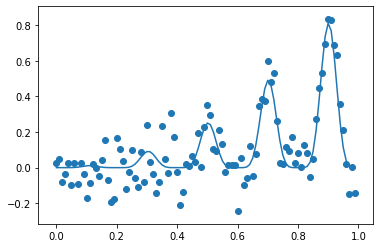

In [16]:
# plot the points with noise
pyplot.scatter(X, ynoise)
# plot the points without noise
pyplot.plot(X, y)
# show the plot
pyplot.show()

##### Surrogate Function

In [24]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

In [25]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

In [26]:
# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]

In [27]:
# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()

#### Perform Bayesian Optimization

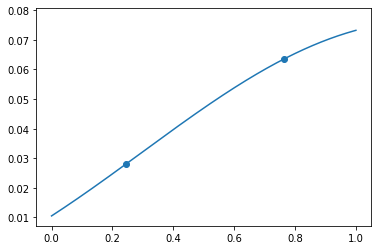

In [48]:
# sample the domain sparsely with noise
X = random(2)
y = asarray([objective(x) for x in X])

# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

# define the model
model = GaussianProcessRegressor()

# fit the model [With intial points]
model.fit(X, y)

# plot before hand
plot(X, y, model)

In [ ]:
# Loop through until it converges. [100 iterations]
# Each iteration, it samples from hyperparameter space and find the best next point. 
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

    # plot all samples and the final surrogate function
    plot(X, y, model)
    # best result
    ix = argmax(y)
    print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))